In [1]:
import tensorflow as tf

print(tf.__version__, tf.config.list_physical_devices())

2025-03-20 01:49:41.152412: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-20 01:49:41.177266: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-20 01:49:41.184886: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-20 01:49:41.205213: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.17.0 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1742435384.969571   92716 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1742435384.978071   92716 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1742435384.978172   92716 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
from keras.datasets import mnist, boston_housing  # MNIST dataset
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, Callback
from keras.regularizers import l2
from keras import models
from keras import layers
from matplotlib import pyplot as plt
from timeit import default_timer as timer
import pandas as pd
import seaborn as sns
import statistics
import pickle

In [3]:
class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_train_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_train_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

In [4]:
# val_size_pointer = int(len(X_train)*0.2)
num_of_test = 5
eps_bath_size_pair = [(10, 128), (10, 8), (50, 128)]

def train_network(
    path: str,
    eps_bath_size_pair: list[tuple[int, int]],
    input_lay,
    output_lay,
    loss_func: str,
    metrics: list[str],
    X_train,
    y_train,
    X_test,
    y_test,
):
    logs = dict()
    for eps, bath_size in eps_bath_size_pair:
        for test_time in range(num_of_test):
            log_id = f"e{eps}_b{bath_size}_t{test_time}"
            network = models.Sequential(
                [
                    input_lay,
                    layers.Dense(512, activation="relu"),
                    layers.Dense(256, activation="relu"),
                    layers.Dense(128, activation="relu"),
                    output_lay,
                ]
            )
            network.compile(optimizer="adam", loss=loss_func, metrics=metrics)

            cb = ModelCheckpoint(
                filepath=f"{path}/{log_id}.weights.h5",
                monitor="val_loss",
                save_best_only=True,
                save_weights_only=True,
            )
            timer_cb = TimingCallback()
            his = network.fit(
                X_train,
                y_train,
                epochs=eps,
                batch_size=bath_size,
                validation_split=0.2,
                verbose=0,
                callbacks=[cb, timer_cb],
            )
            network.load_weights(f"{path}/{log_id}.weights.h5")
            test_logs = network.evaluate(X_test, y_test, verbose=0, return_dict=True)
            logs[log_id] = his.history
            for key in test_logs.keys():
                logs[log_id][f"test_{key}"] = test_logs[key]
            logs[log_id]["train_time"] = timer_cb.logs[0]
    return logs

## MNIST

In [5]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape((-1, 28 * 28)).astype("float32") / 255
X_test = X_test.reshape((-1, 28 * 28)).astype("float32") / 255

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [6]:
logs = train_network(
    "./weights/Q3/mnist",
    eps_bath_size_pair,
    layers.Input(shape=(28 * 28,)),
    layers.Dense(10, activation="softmax"),
    "categorical_crossentropy",
    ["accuracy"],
    X_train,
    y_train,
    X_test,
    y_test,
)
pickle.dump(logs, open("q3_mnist_logs.pkl", "wb"))

I0000 00:00:1742435386.365941   92716 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1742435386.366112   92716 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1742435386.366253   92716 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1742435386.989334   92716 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1742435386.989417   92716 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-20

In [25]:
logs = pickle.load(open("q3_mnist_logs.pkl", "rb"))
logs_df = pd.DataFrame(logs).T
logs_df = logs_df.reset_index()
logs_df["eps"] = logs_df["index"].str.split("_").str[0].str[1:].astype(int)
logs_df["batch_size"] = logs_df["index"].str.split("_").str[1].str[1:].astype(int)

In [26]:
logs_df.groupby(["eps", "batch_size"])[
    ["test_loss", "test_accuracy", "train_time"]
].mean()

test_loss test_accuracy  train_time
eps batch_size                                    
10  8           0.095062        0.9738  343.073895
    128          0.07327       0.97796   60.309137
50  128         0.079153       0.97682  128.540156

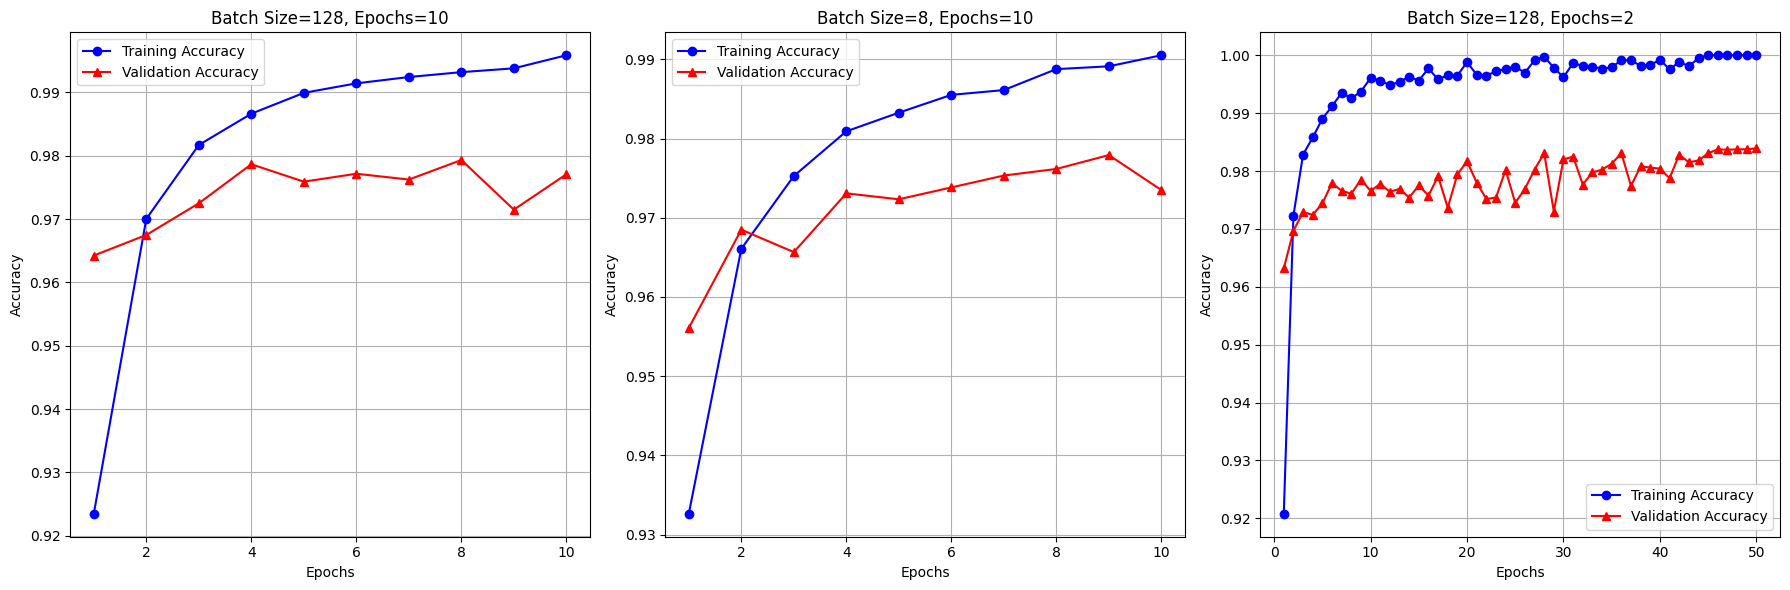

In [28]:
plt.figure(figsize=(18, 6))

epochs_range1 = range(1, 11)
# 原始設置 (batch_size=128, epochs=10)
plt.subplot(1, 3, 1)
plt.plot(epochs_range1, logs["e10_b128_t0"]['accuracy'], 'bo-', label="Training Accuracy")
plt.plot(epochs_range1, logs["e10_b128_t0"]['val_accuracy'], 'r^-', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Batch Size=128, Epochs=10")
plt.legend()
plt.grid(True)

# 更改 batch_size=8 (epochs=10)
plt.subplot(1, 3, 2)
plt.plot(epochs_range1, logs["e10_b8_t0"]['accuracy'], 'bo-', label="Training Accuracy")
plt.plot(epochs_range1, logs["e10_b8_t0"]['val_accuracy'], 'r^-', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Batch Size=8, Epochs=10")
plt.legend()
plt.grid(True)

epochs_range3 = range(1, 51)
# 更改 epochs=50 (batch_size=128)
plt.subplot(1, 3, 3)
plt.plot(epochs_range3, logs["e50_b128_t0"]['accuracy'], 'bo-', label="Training Accuracy")
plt.plot(epochs_range3, logs["e50_b128_t0"]['val_accuracy'], 'r^-', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Batch Size=128, Epochs=2")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## boston_housing

In [21]:
(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

m = X_train.mean(axis=0)
s = X_train.std(axis=0)

X_train -= m
X_train /= s

X_test -= m
X_test /= s

In [22]:
logs = train_network(
    "./weights/Q3/boston",
    eps_bath_size_pair,
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(1),
    "mean_squared_error",
    [
        "mean_absolute_error",
        "root_mean_squared_error",
        "mean_absolute_percentage_error",
    ],
    X_train,
    y_train,
    X_test,
    y_test,
)
pickle.dump(logs, open("q3_boston_housing_logs.pkl", "wb"))

In [30]:
logs = pickle.load(open("q3_boston_housing_logs.pkl", "rb"))
logs_df = pd.DataFrame(logs).T
logs_df = logs_df.reset_index()
logs_df["eps"] = logs_df["index"].str.split("_").str[0].str[1:].astype(int)
logs_df["batch_size"] = logs_df["index"].str.split("_").str[1].str[1:].astype(int)

In [31]:
logs_df.groupby(["eps", "batch_size"])[
    ["test_loss", "test_mean_absolute_error", "test_mean_absolute_percentage_error", "test_root_mean_squared_error", "train_time"]
].mean()

test_loss test_mean_absolute_error  \
eps batch_size                                       
10  8           23.175018                 3.224661   
    128         43.408963                 5.014637   
50  128         26.324651                 3.298379   

               test_mean_absolute_percentage_error  \
eps batch_size                                       
10  8                                    15.999965   
    128                                  24.085283   
50  128                                  16.634603   

               test_root_mean_squared_error train_time  
eps batch_size                                          
10  8                              4.807621   8.681788  
    128                            6.587436   6.910287  
50  128                            5.129982  11.543302

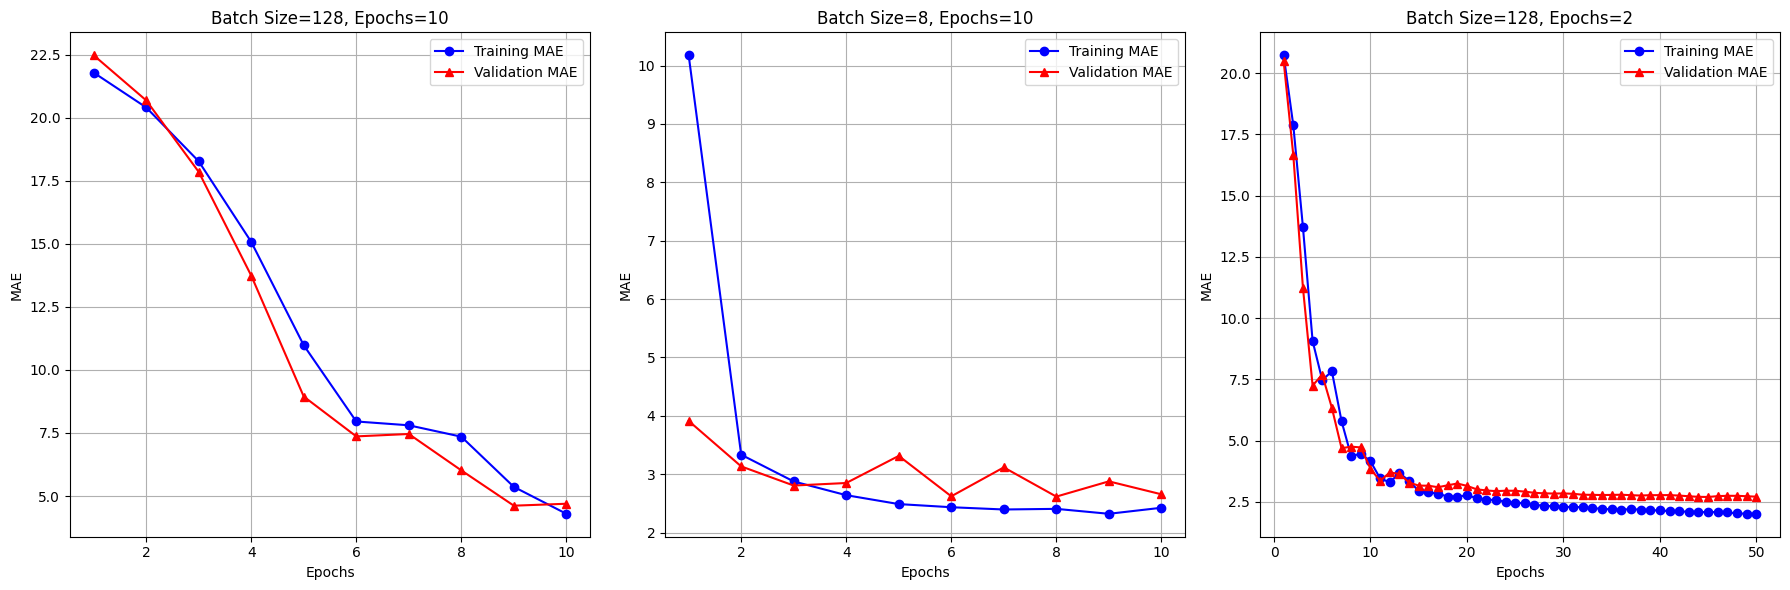

In [32]:
plt.figure(figsize=(18, 6))

epochs_range1 = range(1, 11)
# 原始設置 (batch_size=128, epochs=10)
plt.subplot(1, 3, 1)
plt.plot(epochs_range1, logs["e10_b128_t0"]['mean_absolute_error'], 'bo-', label="Training MAE")
plt.plot(epochs_range1, logs["e10_b128_t0"]['val_mean_absolute_error'], 'r^-', label="Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Batch Size=128, Epochs=10")
plt.legend()
plt.grid(True)

# 更改 batch_size=8 (epochs=10)
plt.subplot(1, 3, 2)
plt.plot(epochs_range1, logs["e10_b8_t0"]['mean_absolute_error'], 'bo-', label="Training MAE")
plt.plot(epochs_range1, logs["e10_b8_t0"]['val_mean_absolute_error'], 'r^-', label="Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Batch Size=8, Epochs=10")
plt.legend()
plt.grid(True)

epochs_range3 = range(1, 51)
# 更改 epochs=50 (batch_size=128)
plt.subplot(1, 3, 3)
plt.plot(epochs_range3, logs["e50_b128_t0"]['mean_absolute_error'], 'bo-', label="Training MAE")
plt.plot(epochs_range3, logs["e50_b128_t0"]['val_mean_absolute_error'], 'r^-', label="Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Batch Size=128, Epochs=2")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()